# 甲状腺組織画像の識別に関する研究
## 画像識別プログラム

## ライブラリ読み込み，ランダムシード固定

In [12]:
import random

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.models import resnet50
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

%matplotlib inline

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

### subsetにtransformを適用するためのクラス
### （subsetを直接transformすることはできない）

In [13]:
class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

### datasetを訓練用と検証用に分割する関数

In [14]:
def make_datasets(dataset, train_indices, val_indices,
                  train_trans=None, val_trans=None):
    train_subset = torch.utils.data.Subset(dataset, train_indices)
    val_subset = torch.utils.data.Subset(dataset, val_indices)
    train_dataset = DatasetFromSubset(train_subset, train_trans)
    val_dataset = DatasetFromSubset(val_subset, val_trans)
    
    return train_dataset, val_dataset

### size, mean, stdはImageNetで学習したネットワーク使用時に必要な変換処理

In [15]:
class ImageTransform():
    def __init__(self):
        self.data_transform = {
            'train':transforms.Compose([
                transforms.RandomResizedCrop(size, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ToTensor(),
    transforms.Normalize(mean, std)]),
               "val": transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)]
            ])
        }


size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transformer = {"train": transforms.Compose([
    transforms.RandomResizedCrop(size, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)]),
               "val": transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])}

In [19]:
data_path = "./data/"
dataset = ImageFolder(data_path + "train")
print(dataset.class_to_idx)

{'normal': 0, 'ptc_he': 1, 'unknown': 2}


### ネットワークの初期化をする関数

In [20]:
def init_net():
    net = resnet50(pretrained=True)
    for p in net.parameters():
        p.requires_grad = False
    
    fc_input_dim = net.fc.in_features
    net.fc = nn.Linear(fc_input_dim, 3)
    
    return net

### ネットワークの検証と訓練を実行する関数

In [21]:
def eval_net(net, loader, device="cpu"):
    net.eval()
    ys = []
    ypreds = []
    
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            ypred = net(x).argmax(1)
        ys.append(y)
        ypreds.append(ypred)
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    
    return ys, ypreds

train_losses = []
train_acc = []
val_acc = []

def train_net(net, train_loader, test_loader, optimizer_cls=optim.Adam,
              loss_fn=nn.CrossEntropyLoss(), n_iter=10, only_fc=True):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    
    net = net.to(device)
    
    if only_fc:
        optimizer = optimizer_cls(net.fc.parameters())
    else:
        optimizer = optimizer_cls(net.parameters())
    '''
    optimizer = optim.Adam([
        #{"params": params_to_update_1, "lr": 1e-4},
        #{"params": params_to_update_2, "lr": 5e-4},
        {"params": params_to_update_3, "lr": 1e-3}
    ])
    '''
    for epoch in range(n_iter):
        net.train()
        running_loss = 0.0
        n_acc = 0.0
        n = 0
        
        for i, (x, y) in tqdm(enumerate(train_loader),
                              total=len(train_loader)):
            x = x.to(device)
            y = y.to(device)
            h = net(x)
            loss = loss_fn(h, y)
            net.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            ypred = h.argmax(1)
            n_acc += (y == ypred).float().sum().item()
            n += len(x)
            
        train_losses.append(running_loss / i)
        train_acc.append(n_acc / n)
        val_ys, val_ypreds = eval_net(net, test_loader, device=device)
        val_acc.append(((val_ys == val_ypreds).float().sum() / len(val_ys)).item())
        print("epoch:{}/{}  train_loss: {:.3f}  train_acc: {:.3f}  val_acc: {:.3f}".format(
        epoch+1, n_iter, train_losses[-1], train_acc[-1], val_acc[-1]), flush=True)

In [22]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

ys = []
ypreds = []

for cv_num, (train_indices, val_indices) in enumerate(skf.split(
    dataset, dataset.targets)):
    
    print("交差検証：{}/{}".format(cv_num+1, skf.get_n_splits()))
    
    train_dataset, val_dataset = make_datasets(
        dataset,
        train_indices,
        val_indices,
        train_trans=transformer["train"],
        val_trans=transformer["val"])

    train_loader = DataLoader(train_dataset, batch_size=128,
                              shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=128,
                            shuffle=False, num_workers=8)
    
    net = init_net()
    
    train_net(net, train_loader, val_loader, n_iter=10)
    ys_ypreds = eval_net(net, val_loader, device="cuda:0")
    ys.append(ys_ypreds[0])
    ypreds.append(ys_ypreds[1])
    
ys = torch.cat(ys).cpu().numpy()
ypreds = torch.cat(ypreds).cpu().numpy()

交差検証：1/3
使用デバイス： cuda:0


100%|██████████| 27/27 [00:11<00:00,  2.35it/s]


epoch:1/10  train_loss: 0.550  train_acc: 0.846  val_acc: 0.918


100%|██████████| 27/27 [00:11<00:00,  2.26it/s]


epoch:2/10  train_loss: 0.276  train_acc: 0.924  val_acc: 0.936


100%|██████████| 27/27 [00:11<00:00,  2.34it/s]


epoch:3/10  train_loss: 0.226  train_acc: 0.937  val_acc: 0.941


100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


epoch:4/10  train_loss: 0.210  train_acc: 0.940  val_acc: 0.946


100%|██████████| 27/27 [00:11<00:00,  2.32it/s]


epoch:5/10  train_loss: 0.190  train_acc: 0.938  val_acc: 0.954


100%|██████████| 27/27 [00:11<00:00,  2.33it/s]


epoch:6/10  train_loss: 0.176  train_acc: 0.945  val_acc: 0.956


100%|██████████| 27/27 [00:11<00:00,  2.32it/s]


epoch:7/10  train_loss: 0.170  train_acc: 0.947  val_acc: 0.950


100%|██████████| 27/27 [00:11<00:00,  2.27it/s]


epoch:8/10  train_loss: 0.171  train_acc: 0.948  val_acc: 0.958


100%|██████████| 27/27 [00:11<00:00,  2.34it/s]


epoch:9/10  train_loss: 0.154  train_acc: 0.952  val_acc: 0.953


100%|██████████| 27/27 [00:11<00:00,  2.36it/s]


epoch:10/10  train_loss: 0.151  train_acc: 0.952  val_acc: 0.958
交差検証：2/3
使用デバイス： cuda:0


100%|██████████| 27/27 [00:11<00:00,  2.34it/s]


epoch:1/10  train_loss: 0.564  train_acc: 0.827  val_acc: 0.922


100%|██████████| 27/27 [00:11<00:00,  2.33it/s]


epoch:2/10  train_loss: 0.294  train_acc: 0.916  val_acc: 0.932


100%|██████████| 27/27 [00:11<00:00,  2.33it/s]


epoch:3/10  train_loss: 0.239  train_acc: 0.931  val_acc: 0.944


100%|██████████| 27/27 [00:11<00:00,  2.33it/s]


epoch:4/10  train_loss: 0.215  train_acc: 0.935  val_acc: 0.945


100%|██████████| 27/27 [00:11<00:00,  2.34it/s]


epoch:5/10  train_loss: 0.193  train_acc: 0.943  val_acc: 0.950


100%|██████████| 27/27 [00:11<00:00,  2.33it/s]


epoch:6/10  train_loss: 0.184  train_acc: 0.945  val_acc: 0.952


100%|██████████| 27/27 [00:11<00:00,  2.34it/s]


epoch:7/10  train_loss: 0.178  train_acc: 0.943  val_acc: 0.953


100%|██████████| 27/27 [00:11<00:00,  2.31it/s]


epoch:8/10  train_loss: 0.166  train_acc: 0.950  val_acc: 0.950


100%|██████████| 27/27 [00:11<00:00,  2.30it/s]


epoch:9/10  train_loss: 0.171  train_acc: 0.949  val_acc: 0.954


100%|██████████| 27/27 [00:11<00:00,  2.31it/s]


epoch:10/10  train_loss: 0.166  train_acc: 0.947  val_acc: 0.956
交差検証：3/3
使用デバイス： cuda:0


100%|██████████| 27/27 [00:11<00:00,  2.33it/s]


epoch:1/10  train_loss: 0.522  train_acc: 0.845  val_acc: 0.923


100%|██████████| 27/27 [00:11<00:00,  2.31it/s]


epoch:2/10  train_loss: 0.260  train_acc: 0.925  val_acc: 0.942


100%|██████████| 27/27 [00:11<00:00,  2.39it/s]


epoch:3/10  train_loss: 0.218  train_acc: 0.934  val_acc: 0.939


100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


epoch:4/10  train_loss: 0.189  train_acc: 0.947  val_acc: 0.941


100%|██████████| 27/27 [00:11<00:00,  2.35it/s]


epoch:5/10  train_loss: 0.173  train_acc: 0.948  val_acc: 0.948


100%|██████████| 27/27 [00:11<00:00,  2.36it/s]


epoch:6/10  train_loss: 0.160  train_acc: 0.950  val_acc: 0.947


100%|██████████| 27/27 [00:11<00:00,  2.34it/s]


epoch:7/10  train_loss: 0.157  train_acc: 0.949  val_acc: 0.950


100%|██████████| 27/27 [00:11<00:00,  2.39it/s]


epoch:8/10  train_loss: 0.155  train_acc: 0.952  val_acc: 0.949


100%|██████████| 27/27 [00:11<00:00,  2.35it/s]


epoch:9/10  train_loss: 0.151  train_acc: 0.950  val_acc: 0.950


100%|██████████| 27/27 [00:11<00:00,  2.33it/s]


epoch:10/10  train_loss: 0.140  train_acc: 0.955  val_acc: 0.953


In [23]:
print(accuracy_score(ys, ypreds))
print(confusion_matrix(ys, ypreds))
print(classification_report(ys, ypreds,
                            target_names=["normal", "ptc_he", "unknown"]))

0.9554907677356657
[[3529   11    3]
 [   9 1248   35]
 [  72   99  139]]
              precision    recall  f1-score   support

      normal       0.98      1.00      0.99      3543
      ptc_he       0.92      0.97      0.94      1292
     unknown       0.79      0.45      0.57       310

    accuracy                           0.96      5145
   macro avg       0.89      0.80      0.83      5145
weighted avg       0.95      0.96      0.95      5145



### （正解：予測）＝（正常：腫瘍）or（腫瘍：正常）の画像を表示する

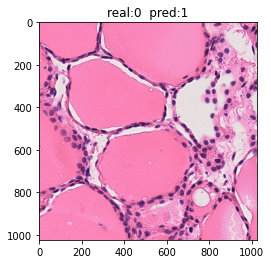

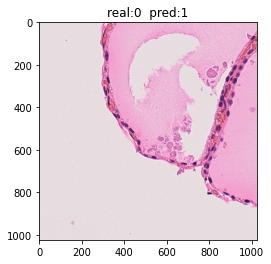

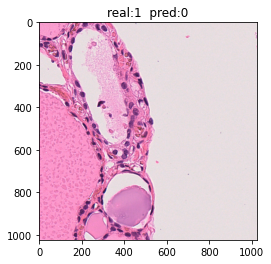

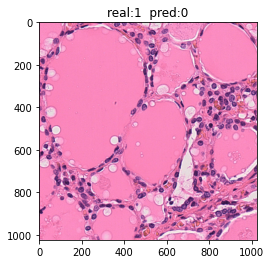

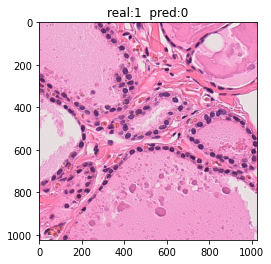

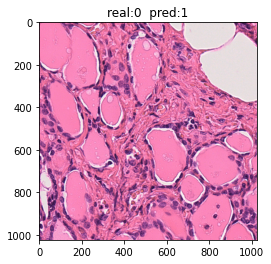

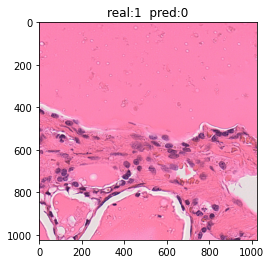

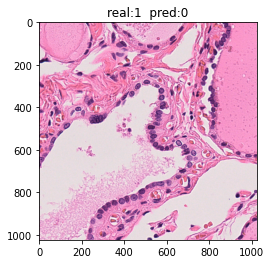

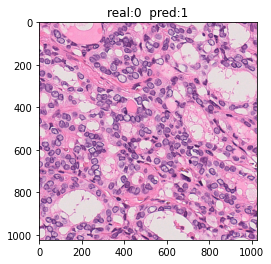

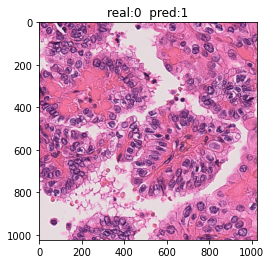

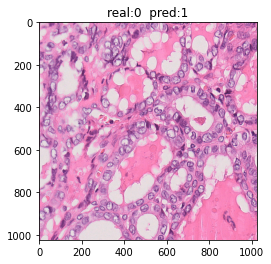

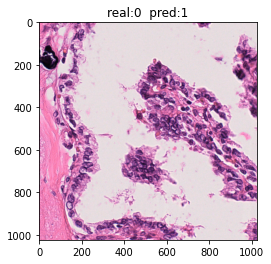

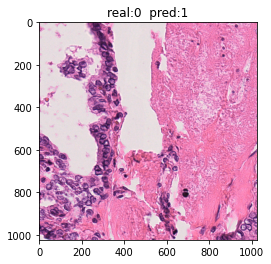

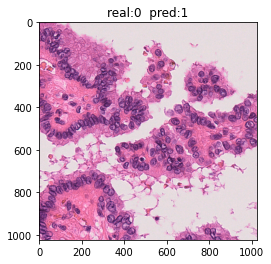

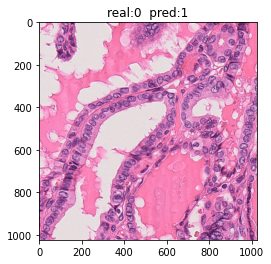

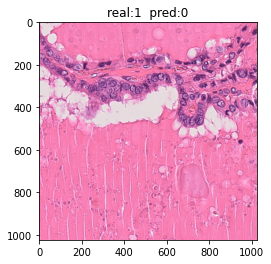

In [14]:
train_dataset_not_transform = ImageFolder(data_path + "train")

for i in range(len(ys)):
    if ((ys[i]==0) and (ypreds[i]==1)) or ((ys[i]==1) and (ypreds[i]==0)):
        img = train_dataset_not_transform[i][0]
        plt.imshow(img)
        plt.title("real:{}  pred:{}".format(ys[i], ypreds[i]))
        plt.show()

### テスト用データの識別

In [9]:
data_path = "/home/yochimonji/data/learning_medical_thyroid/"
train_dataset = ImageFolder(data_path + "train",
                            transform=transformer["train"])
test_dataset = ImageFolder(data_path + "test",
                           transform=transformer["val"])

train_loader = DataLoader(train_dataset, batch_size=64,
                          shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=64,
                         shuffle=False, num_workers=8)
    

In [18]:
net = init_net()
    
train_net(net, train_loader, test_loader, n_iter=30)

使用デバイス： cuda:0


100%|██████████| 81/81 [00:15<00:00,  5.13it/s]


epoch:1/30  train_loss: 0.366  train_acc: 0.884  val_acc: 0.503


100%|██████████| 81/81 [00:15<00:00,  5.14it/s]


epoch:2/30  train_loss: 0.212  train_acc: 0.934  val_acc: 0.516


100%|██████████| 81/81 [00:15<00:00,  5.14it/s]


epoch:3/30  train_loss: 0.173  train_acc: 0.948  val_acc: 0.516


100%|██████████| 81/81 [00:15<00:00,  5.12it/s]


epoch:4/30  train_loss: 0.168  train_acc: 0.942  val_acc: 0.522


100%|██████████| 81/81 [00:15<00:00,  5.11it/s]


epoch:5/30  train_loss: 0.162  train_acc: 0.945  val_acc: 0.486


100%|██████████| 81/81 [00:15<00:00,  5.11it/s]


epoch:6/30  train_loss: 0.154  train_acc: 0.952  val_acc: 0.529


100%|██████████| 81/81 [00:15<00:00,  5.12it/s]


epoch:7/30  train_loss: 0.155  train_acc: 0.946  val_acc: 0.528


100%|██████████| 81/81 [00:15<00:00,  5.14it/s]


epoch:8/30  train_loss: 0.145  train_acc: 0.952  val_acc: 0.533


100%|██████████| 81/81 [00:15<00:00,  5.12it/s]


epoch:9/30  train_loss: 0.141  train_acc: 0.951  val_acc: 0.535


100%|██████████| 81/81 [00:15<00:00,  5.13it/s]


epoch:10/30  train_loss: 0.147  train_acc: 0.951  val_acc: 0.516


100%|██████████| 81/81 [00:15<00:00,  5.11it/s]


epoch:11/30  train_loss: 0.146  train_acc: 0.946  val_acc: 0.523


100%|██████████| 81/81 [00:15<00:00,  5.11it/s]


epoch:12/30  train_loss: 0.134  train_acc: 0.952  val_acc: 0.539


100%|██████████| 81/81 [00:15<00:00,  5.10it/s]


epoch:13/30  train_loss: 0.134  train_acc: 0.952  val_acc: 0.506


100%|██████████| 81/81 [00:15<00:00,  5.10it/s]


epoch:14/30  train_loss: 0.136  train_acc: 0.952  val_acc: 0.510


100%|██████████| 81/81 [00:15<00:00,  5.10it/s]


epoch:15/30  train_loss: 0.132  train_acc: 0.955  val_acc: 0.538


100%|██████████| 81/81 [00:16<00:00,  5.05it/s]


epoch:16/30  train_loss: 0.137  train_acc: 0.952  val_acc: 0.523


100%|██████████| 81/81 [00:15<00:00,  5.11it/s]


epoch:17/30  train_loss: 0.139  train_acc: 0.954  val_acc: 0.528


100%|██████████| 81/81 [00:15<00:00,  5.11it/s]


epoch:18/30  train_loss: 0.135  train_acc: 0.953  val_acc: 0.530


100%|██████████| 81/81 [00:15<00:00,  5.11it/s]


epoch:19/30  train_loss: 0.120  train_acc: 0.957  val_acc: 0.517


100%|██████████| 81/81 [00:15<00:00,  5.11it/s]


epoch:20/30  train_loss: 0.122  train_acc: 0.957  val_acc: 0.528


100%|██████████| 81/81 [00:15<00:00,  5.08it/s]


epoch:21/30  train_loss: 0.127  train_acc: 0.956  val_acc: 0.511


100%|██████████| 81/81 [00:15<00:00,  5.11it/s]


epoch:22/30  train_loss: 0.132  train_acc: 0.956  val_acc: 0.508


100%|██████████| 81/81 [00:15<00:00,  5.10it/s]


epoch:23/30  train_loss: 0.122  train_acc: 0.956  val_acc: 0.516


100%|██████████| 81/81 [00:15<00:00,  5.11it/s]


epoch:24/30  train_loss: 0.128  train_acc: 0.956  val_acc: 0.531


100%|██████████| 81/81 [00:15<00:00,  5.09it/s]


epoch:25/30  train_loss: 0.122  train_acc: 0.957  val_acc: 0.490


100%|██████████| 81/81 [00:15<00:00,  5.11it/s]


epoch:26/30  train_loss: 0.116  train_acc: 0.961  val_acc: 0.537


100%|██████████| 81/81 [00:15<00:00,  5.11it/s]


epoch:27/30  train_loss: 0.122  train_acc: 0.957  val_acc: 0.528


100%|██████████| 81/81 [00:15<00:00,  5.10it/s]


epoch:28/30  train_loss: 0.113  train_acc: 0.962  val_acc: 0.512


100%|██████████| 81/81 [00:15<00:00,  5.11it/s]


epoch:29/30  train_loss: 0.116  train_acc: 0.958  val_acc: 0.532


100%|██████████| 81/81 [00:15<00:00,  5.13it/s]


epoch:30/30  train_loss: 0.116  train_acc: 0.959  val_acc: 0.541


In [19]:
save_path = "./weights_classification_thyroid.pth"
torch.save(net.state_dict(), save_path)

In [10]:
net = init_net()
load_path = "./weights_classification_thyroid.pth"
load_weights = torch.load(load_path)
net.load_state_dict(load_weights)
net = net.to("cuda:0")

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

ys, ypreds = eval_net(net, test_loader, device="cuda:0")
ys = ys.cpu().numpy()
ypreds = ypreds.cpu().numpy()
print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)
print(accuracy_score(ys, ypreds))
print(confusion_matrix(ys, ypreds))
print(classification_report(ys, ypreds,
                            target_names=["normal", "ptc_he", "unknown"]))

{'normal': 0, 'ptc_he': 1, 'unknown': 2}
{'normal': 0, 'ptc_he': 1, 'unknown': 2}
0.5405172413793103
[[177   2   1]
 [ 15 440   0]
 [497  18  10]]
              precision    recall  f1-score   support

      normal       0.26      0.98      0.41       180
      ptc_he       0.96      0.97      0.96       455
     unknown       0.91      0.02      0.04       525

    accuracy                           0.54      1160
   macro avg       0.71      0.66      0.47      1160
weighted avg       0.83      0.54      0.46      1160



### （正解：予測）＝（正常：腫瘍）or（腫瘍：正常）の画像を表示する

{'normal': 0, 'ptc_he': 1, 'unknown': 2}


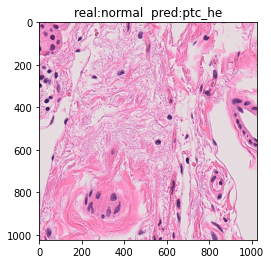

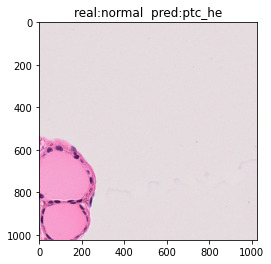

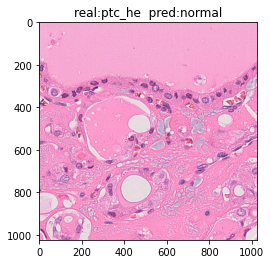

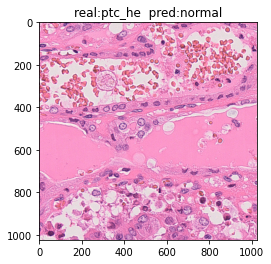

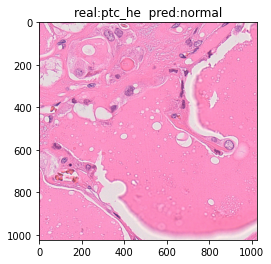

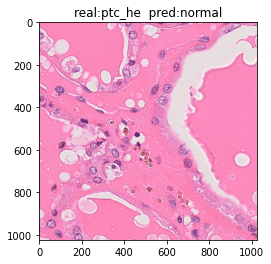

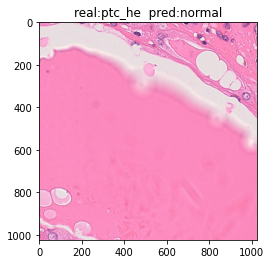

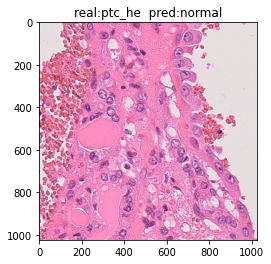

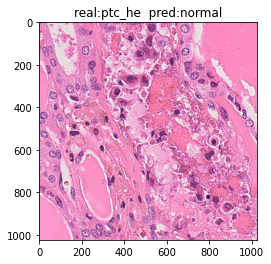

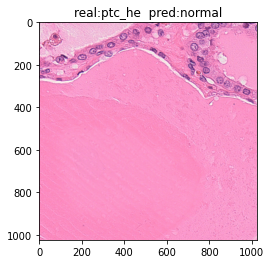

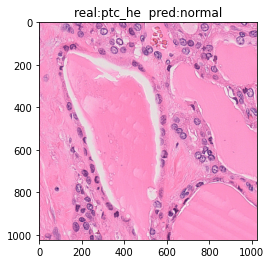

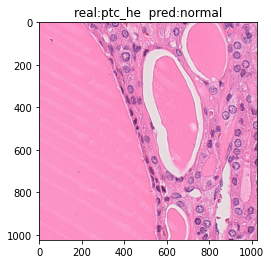

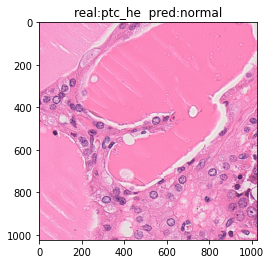

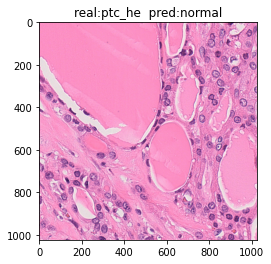

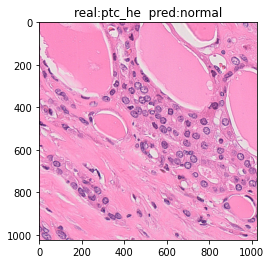

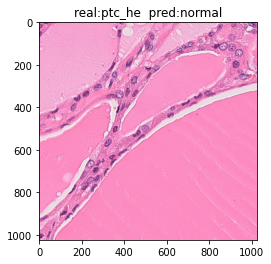

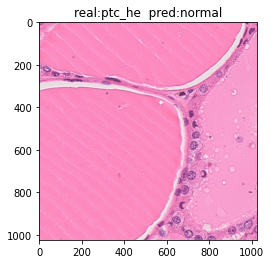

In [15]:
# print(len(dataset), len(train_dataset), len(test_dataset))
print(test_dataset.class_to_idx)
test_dataset_not_transform = ImageFolder(data_path + "test")

for i in range(len(ys)):
    if ((ys[i]==0) and (ypreds[i]==1)) or ((ys[i]==1) and (ypreds[i]==0)):
        if ys[i]==0:
            real = "normal"
            pred = "ptc_he"
        else:
            real = "ptc_he"
            pred = "normal"
        img = test_dataset_not_transform[i][0]
        plt.imshow(img)
        plt.title("real:{}  pred:{}".format(real, pred))
        plt.show()